Embeddings shape: (118, 1000)
Running t-SNE on logits...
Running t-SNE on softmaxes...


/tmp/ipykernel_1885409/1919758656.py:48: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


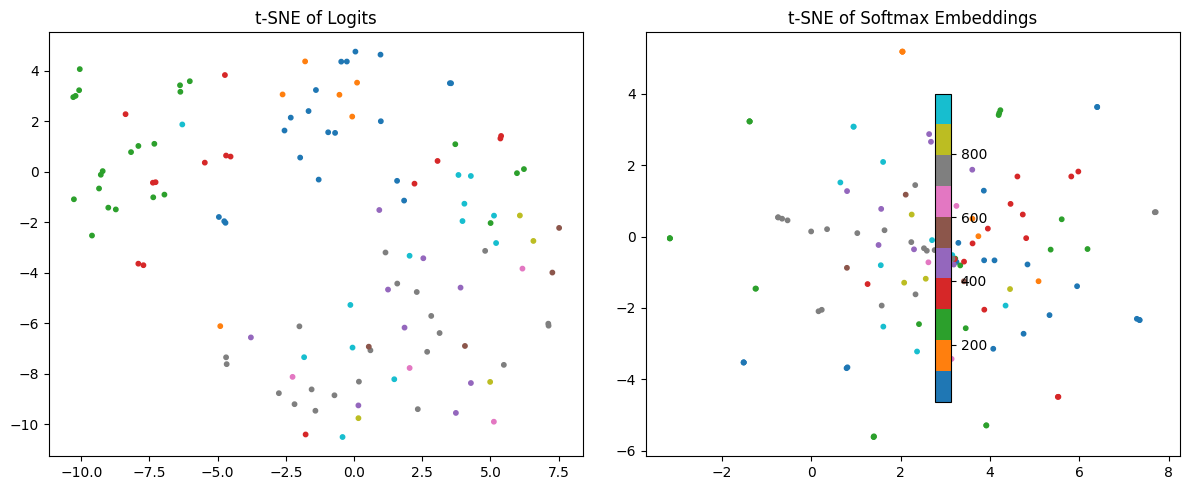

In [ ]:
import numpy as np
import pickle
from scipy.special import softmax
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# --- Load ViT logits ---
path = '/home/maria/Documents/HuggingMouseData/MouseViTEmbeddings/google_vit-base-patch16-224_embeddings_logits.pkl'

with open(path, 'rb') as f:
    vit_dict = pickle.load(f)['natural_scenes']

# vit_dict is expected to be {image_id: logits_vector}
embeddings = np.stack(list(vit_dict))
print("Embeddings shape:", embeddings.shape)

# --- Compute softmax embeddings ---
softmax_embeddings = softmax(embeddings, axis=1)

# --- Run t-SNE on both ---
print("Running t-SNE on logits...")
tsne_logits = TSNE(
    n_components=2, perplexity=30, random_state=42, init='pca', learning_rate='auto'
).fit_transform(embeddings)

print("Running t-SNE on softmaxes...")
tsne_softmax = TSNE(
    n_components=2, perplexity=30, random_state=42, init='pca', learning_rate='auto'
).fit_transform(softmax_embeddings)

# --- Optional: infer pseudo-labels from argmax ---
labels = np.argmax(softmax_embeddings, axis=1)

# --- Plot ---values
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sc1 = axes[0].scatter(
    tsne_logits[:, 0], tsne_logits[:, 1], c=labels, cmap='tab10', s=10
)
axes[0].set_title("t-SNE of Logits")

sc2 = axes[1].scatter(
    tsne_softmax[:, 0], tsne_softmax[:, 1], c=labels, cmap='tab10', s=10
)
axes[1].set_title("t-SNE of Softmax Embeddings")

plt.colorbar(sc2, ax=axes, shrink=0.8)
plt.tight_layout()
plt.show()


Embeddings shape: (118, 1000)
Running t-SNE on logits...
Running t-SNE on softmaxes...
Running t-SNE on CLR-softmax...


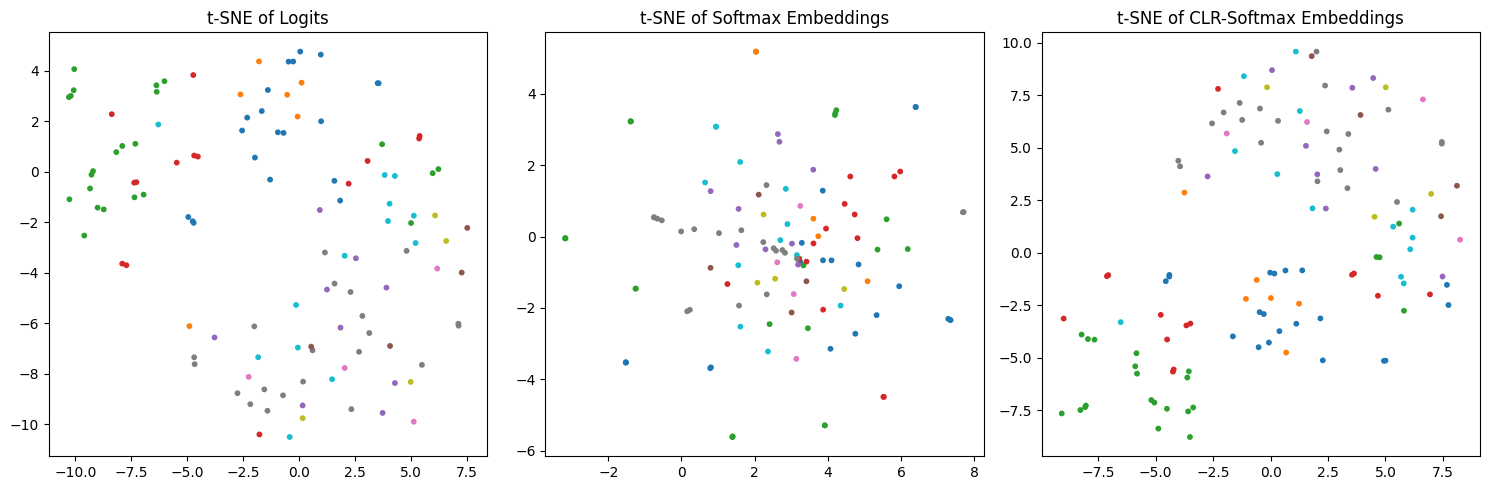

In [6]:
import numpy as np
import pickle
from scipy.special import softmax
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from skbio.stats.composition import clr

# --- Load ViT logits ---
path = '/home/maria/Documents/HuggingMouseData/MouseViTEmbeddings/google_vit-base-patch16-224_embeddings_logits.pkl'

with open(path, 'rb') as f:
    vit_dict = pickle.load(f)['natural_scenes']

# vit_dict is expected to be {image_id: logits_vector}
embeddings = np.stack(list(vit_dict))
print("Embeddings shape:", embeddings.shape)

# --- Compute softmax embeddings ---
softmax_embeddings = softmax(embeddings, axis=1)

# --- Apply CLR transform (requires strictly positive entries) ---
# Add a small epsilon to avoid log(0)
eps = 1e-10
clr_embeddings = clr(softmax_embeddings + eps)

# --- Run t-SNE on all three representations ---
print("Running t-SNE on logits...")
tsne_logits = TSNE(
    n_components=2, perplexity=30, random_state=42, init='pca', learning_rate='auto'
).fit_transform(embeddings)

print("Running t-SNE on softmaxes...")
tsne_softmax = TSNE(
    n_components=2, perplexity=30, random_state=42, init='pca', learning_rate='auto'
).fit_transform(softmax_embeddings)

print("Running t-SNE on CLR-softmax...")
tsne_clr = TSNE(
    n_components=2, perplexity=30, random_state=42, init='pca', learning_rate='auto'
).fit_transform(clr_embeddings)

# --- Color by argmax class (pseudo-label) ---
labels = np.argmax(softmax_embeddings, axis=1)

# --- Plot ---
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].scatter(tsne_logits[:, 0], tsne_logits[:, 1], c=labels, cmap='tab10', s=10)
axes[0].set_title("t-SNE of Logits")

axes[1].scatter(tsne_softmax[:, 0], tsne_softmax[:, 1], c=labels, cmap='tab10', s=10)
axes[1].set_title("t-SNE of Softmax Embeddings")

axes[2].scatter(tsne_clr[:, 0], tsne_clr[:, 1], c=labels, cmap='tab10', s=10)
axes[2].set_title("t-SNE of CLR-Softmax Embeddings")

plt.tight_layout()
plt.show()


In [9]:
from pathlib import Path
from allensdk.core.brain_observatory_cache import BrainObservatoryCache
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt
import os

def tsne_embed_allen_raw(cache_path: str | None = "/home/maria/Documents/AllenBrainObservatory", perplexity: int = 30, n_frames: int = 300):
    """
    Load natural movie stimuli from the Allen Brain Observatory cache
    and embed raw image pixels using t-SNE.

    Parameters
    ----------
    cache_path : str or None
        Path to the AllenSDK cache directory. If None, uses HGMS_ALLEN_CACHE_PATH.
    perplexity : int
        Perplexity parameter for t-SNE.
    n_frames : int
        Number of frames per movie to subsample (for speed).

    Returns
    -------
    dict[str, np.ndarray]
        Dictionary mapping movie name → 2D t-SNE coordinates.
    """
    cache_path = cache_path or os.environ.get("HGMS_ALLEN_CACHE_PATH")
    if cache_path is None:
        raise ValueError("HGMS_ALLEN_CACHE_PATH not set and no cache_path provided.")

    boc = BrainObservatoryCache(
        manifest_file=str(Path(cache_path) / "brain_observatory_manifest.json")
    )

    # Example sessions with natural movies
    sessions = {
        "natural_movie_one": 501704220,
        "natural_movie_two": 501474098,
        "natural_movie_three": 501704220,
    }

    tsne_results = {}

    for movie_name, session_id in sessions.items():
        dataset = boc.get_ophys_experiment_data(session_id)
        stim = dataset.get_stimulus_template(movie_name)  # shape: (frames, height, width)
        print(f"{movie_name}: {stim.shape}")

        # Subsample frames if too many
        if stim.shape[0] > n_frames:
            idx = np.linspace(0, stim.shape[0]-1, n_frames, dtype=int)
            stim = stim[idx]

        # Flatten each frame into a vector
        stim_flat = stim.reshape(stim.shape[0], -1)

        print(f"Running t-SNE on {movie_name} ({stim_flat.shape[0]} frames × {stim_flat.shape[1]} pixels)...")
        tsne_coords = TSNE(
            n_components=2,
            perplexity=perplexity,
            init="pca",
            learning_rate="auto",
            random_state=42,
        ).fit_transform(stim_flat)

        tsne_results[movie_name] = tsne_coords

        # Plot each movie
        plt.figure(figsize=(5, 4))
        plt.scatter(tsne_coords[:, 0], tsne_coords[:, 1], s=10, c=np.arange(len(tsne_coords)), cmap="viridis")
        plt.title(f"t-SNE (raw pixels) – {movie_name}")
        plt.xlabel("Dim 1")
        plt.ylabel("Dim 2")
        plt.tight_layout()
        plt.show()

    return tsne_results

results = tsne_embed_allen_raw()



ModuleNotFoundError: No module named 'allensdk'